In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats
import seaborn as sns
from nltk.util import bigrams
%matplotlib inline
sns.set()

In [2]:
# Set errorbar style
font = {'family' : 'normal',
        'size'   : 15}
FIGSIZE = (13,8)

In [3]:
price_bins = [
    0,
    10,
    20,
    30,
    40,
    50,
    60,
    70,
    80,
    90,
    100,
    200,
    500,
    1000
]

bin_labels = ['{} - {}'.format(b1, b2) for b1, b2 in bigrams(price_bins)]

In [4]:
with open('incent_results.json') as f:
    incent = json.load(f)
    
with open('non_incent_results.json') as f:
    non_incent = json.load(f)

with open('incent_results_2.json') as f:
    incent2 = json.load(f)
    
with open('non_incent_results_2.json') as f:
    non_incent2 = json.load(f)

with open('whole_dataset_results.json') as f:
    whole_dataset = json.load(f)

with open('elec_incent_results.json') as f:
    elec_incent = json.load(f)
    
with open('elec_non_incent_results.json') as f:
    elec_non_incent = json.load(f)

with open('elec_incent_results3.json') as f:
    elec_incent3 = json.load(f)
    
with open('elec_non_incent_results3.json') as f:
    elec_non_incent3 = json.load(f)

In [5]:
def reshape_samples(samples):
    return { k: [sample[k] for sample in samples] for k in samples[0].keys()}

In [6]:
incent = reshape_samples(incent)
non_incent = reshape_samples(non_incent)
whole_dataset = reshape_samples(whole_dataset)
elec_incent = reshape_samples(elec_incent)
elec_non_incent = reshape_samples(elec_non_incent)
incent2 = reshape_samples(incent2)
non_incent2 = reshape_samples(non_incent2)
elec_incent3 = reshape_samples(elec_incent3)
elec_non_incent3 = reshape_samples(elec_non_incent3)

In [7]:
categories = [c['main_category'] for c in incent['avg_length_by_category'][0]]
price_tiers = [c['price_tier'] for c in incent['num_reviews_by_price_tier'][0]]

In [8]:
def reshape_grouped_by_category(data):
    return {c: [group['_c1'] for sample in data for group in sample if group['main_category'] == c] for c in categories}

In [9]:
incent_by_category = {k: reshape_grouped_by_category(v) for k, v in incent.items() if k.endswith('by_category')}
non_incent_by_category = {k: reshape_grouped_by_category(v) for k, v in non_incent.items() if k.endswith('by_category')}
whole_dataset_by_category = {k: reshape_grouped_by_category(v) for k, v in whole_dataset.items() if k.endswith('by_category')}
incent2_by_category = {k: reshape_grouped_by_category(v) for k, v in incent2.items() if k.endswith('by_category')}
non_incent2_by_category = {k: reshape_grouped_by_category(v) for k, v in non_incent2.items() if k.endswith('by_category')}

In [10]:
def reshape_grouped_by_price_tier(data):
    return {t: [group['_c1'] for sample in data for group in sample if group['price_tier'] == t] for t in price_tiers}

In [11]:
incent_by_price_tier = {k: reshape_grouped_by_price_tier(v) for k, v in incent.items() if k.endswith('by_price_tier')}
non_incent_by_price_tier = {k: reshape_grouped_by_price_tier(v) for k, v in non_incent.items() if k.endswith('by_price_tier')}
whole_dataset_by_price_tier = {k: reshape_grouped_by_price_tier(v) for k, v in whole_dataset.items() if k.endswith('by_price_tier')}
elec_incent_by_price_tier = {k: reshape_grouped_by_price_tier(v) for k, v in elec_incent.items() if k.endswith('by_price_tier')}
elec_non_incent_by_price_tier = {k: reshape_grouped_by_price_tier(v) for k, v in elec_non_incent.items() if k.endswith('by_price_tier')}

In [12]:
def reshape_grouped_by_overall(data):
    return {o: [group['_c1'] for sample in data for group in sample if group['overall'] == o] for o in range(1, 6)}

In [13]:
incent_by_overall = {k: reshape_grouped_by_overall(v) for k, v in incent.items() \
                     if (k != ('sentiment_distribution_by_rating')) and (k.endswith('by_overall') or k.endswith('by_rating'))}
non_incent_by_overall = {k: reshape_grouped_by_overall(v) for k, v in non_incent.items() \
                     if (k != ('sentiment_distribution_by_rating')) and (k.endswith('by_overall') or k.endswith('by_rating'))}
whole_dataset_by_overall = {k: reshape_grouped_by_overall(v) for k, v in whole_dataset.items() \
                     if (k != ('sentiment_distribution_by_rating')) and (k.endswith('by_overall') or k.endswith('by_rating'))}
elec_incent_by_overall = {k: reshape_grouped_by_overall(v) for k, v in elec_incent.items() \
                     if (k != ('sentiment_distribution_by_rating')) and (k.endswith('by_overall') or k.endswith('by_rating'))}
elec_non_incent_by_overall = {k: reshape_grouped_by_overall(v) for k, v in elec_non_incent.items() \
                     if (k != ('sentiment_distribution_by_rating')) and (k.endswith('by_overall') or k.endswith('by_rating'))}
incent2_by_overall = {k: reshape_grouped_by_overall(v) for k, v in incent2.items() \
                     if (k != ('sentiment_distribution_by_rating')) and (k.endswith('by_overall') or k.endswith('by_rating'))}
non_incent2_by_overall = {k: reshape_grouped_by_overall(v) for k, v in non_incent2.items() \
                     if (k != ('sentiment_distribution_by_rating')) and (k.endswith('by_overall') or k.endswith('by_rating'))}

In [14]:
def confidence_interval(estimates, confidence=0.95):
    """Return a statistic and its confidence interval of a sequence using bootstrap resampling.
    Computes the statistic over count bootstrap samples drawn from the data, then computes the 
    lower and uppper bounds of the confidence interval.
    """
    # Calculate the confidence interval bounds assuming a normal distribution in
    # the estimates
    m, se = np.mean(estimates), np.std(estimates)
    lower, upper = scipy.stats.norm.interval(confidence, loc=m, scale=se)
    
    return m, lower, upper

def dict_barplot(data, errs, ax=None):
    if ax is None:
        ax = plt.subplot()
    data.plot(kind='bar', ax=ax, yerr=errs, fontsize = 14)
    plt.legend(fontsize=14)

def plot_with_conf_interval(data_incent, data_non_incent, confidence=0.95, ax=None, sort_value=False, normalize=False):
    conf_incent = {k: confidence_interval(v, confidence) for k, v in data_incent.items()}
    means_incent = {k: v[0] for k, v in conf_incent.items()}
    errs_incent = {k: v[2] - v[1] for k, v in conf_incent.items()}
    
    conf_non_incent = {k: confidence_interval(v, confidence) for k, v in data_non_incent.items()}
    means_non_incent = {k: v[0] for k, v in conf_non_incent.items()}
    errs_non_incent = {k: v[2] - v[1] for k, v in conf_non_incent.items()}
    
    df_value = pd.DataFrame({'Incentivized': means_incent, 'Non incentivized': means_non_incent})
    df_error = pd.DataFrame({'Incentivized': errs_incent, 'Non incentivized': errs_non_incent})
    
    if normalize:
        s = df_value.sum(axis=0)
        df_value = df_value/s
        df_error = df_error/s
    
    if sort_value:
        df_value.sort_values(by='Incentivized', inplace=True)
        df_error = df_error.loc[df_value.index.values]
    
    dict_barplot(df_value, df_error, ax=ax) 

# Incentivized

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


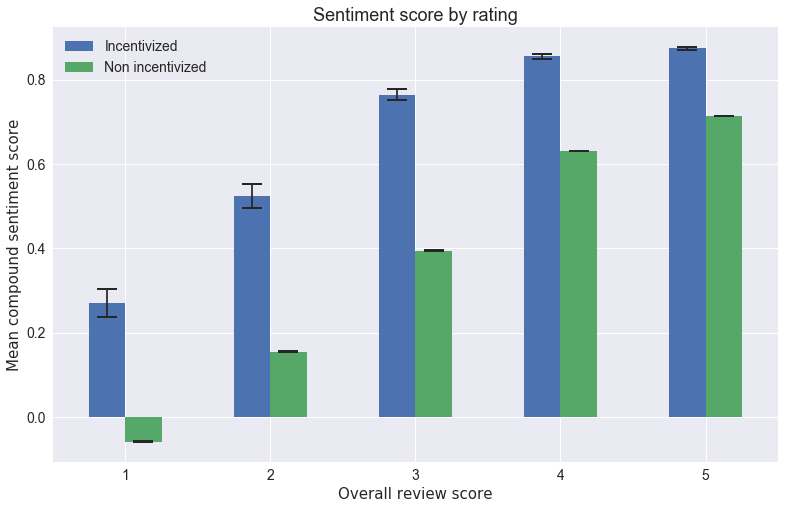

In [15]:
mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2

fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(incent_by_overall['avg_compound_by_rating'], non_incent_by_overall['avg_compound_by_rating'], ax=ax)

ax.set_xlabel('Overall review score', font)
ax.set_ylabel('Mean compound sentiment score', font)
plt.xticks(rotation=0)
plt.title('Sentiment score by rating', fontsize=18)

fig.savefig('sentiment_by_rating.png', bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


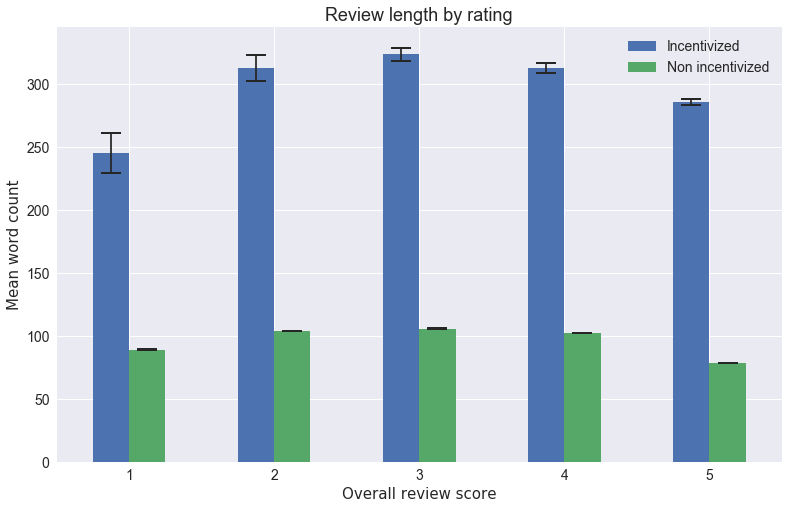

In [16]:
mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2

fig, ax1 = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(incent_by_overall['avg_length_by_overall'], non_incent_by_overall['avg_length_by_overall'], ax=ax1)

ax1.set_xlabel('Overall review score', font)
ax1.set_ylabel('Mean word count', font)
plt.xticks(rotation=0)
plt.title('Review length by rating', fontsize=18)

fig.savefig('wordcount_by_rating.png', bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


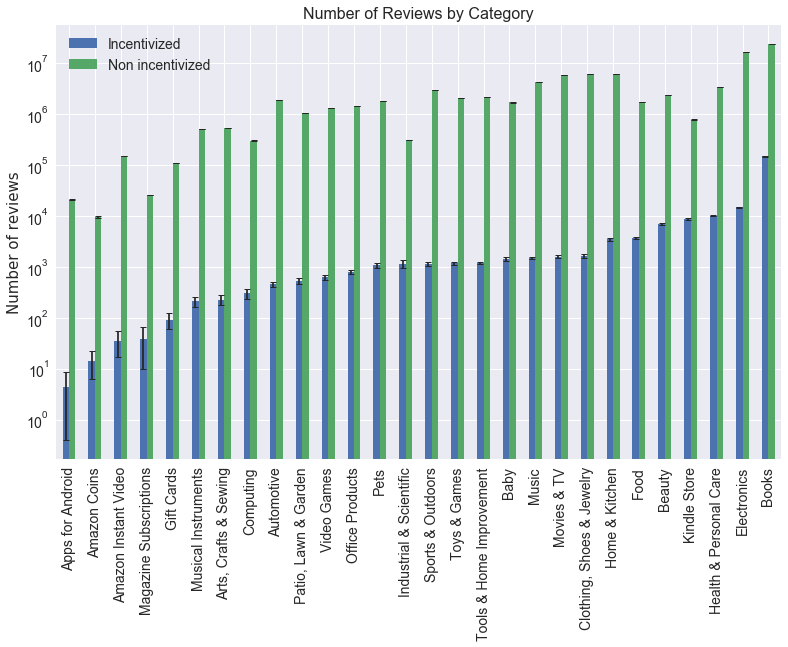

In [17]:
title = 'num_reviews_by_category'

mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(incent_by_category[title], non_incent_by_category[title], ax=ax, sort_value=True)

ax.set_xlabel('', font)
ax.set_ylabel('Number of reviews', font)
ax.set_yscale('log')
plt.title('Number of Reviews by Category', fontsize=16)

fig.savefig(title+'.png', bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


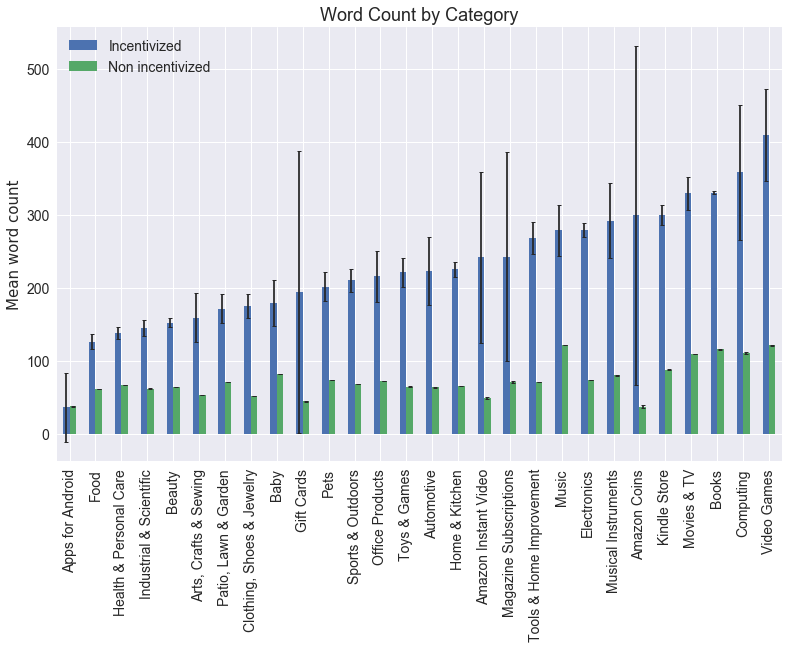

In [35]:
title = 'avg_length_by_category'

mpl.rcParams['errorbar.capsize'] = 2
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(incent_by_category[title], non_incent_by_category[title], ax=ax, sort_value=True)

ax.set_xlabel('', font)
ax.set_ylabel('Mean word count', font)
plt.title('Word Count by Category', fontsize=18)

fig.savefig(title + '.png', bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


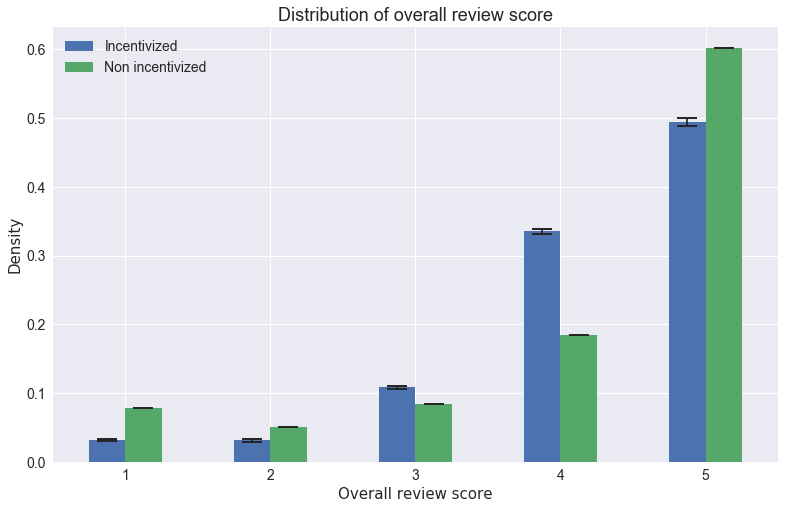

In [19]:
title = 'count_by_overall'

mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2

fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(incent2_by_overall[title], non_incent2_by_overall[title], ax=ax, normalize=True)

ax.set_xlabel('Overall review score', font)
ax.set_ylabel('Density', font)
plt.xticks(rotation=0)
plt.title('Distribution of overall review score', fontsize=18)

fig.savefig(title+'.png', bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


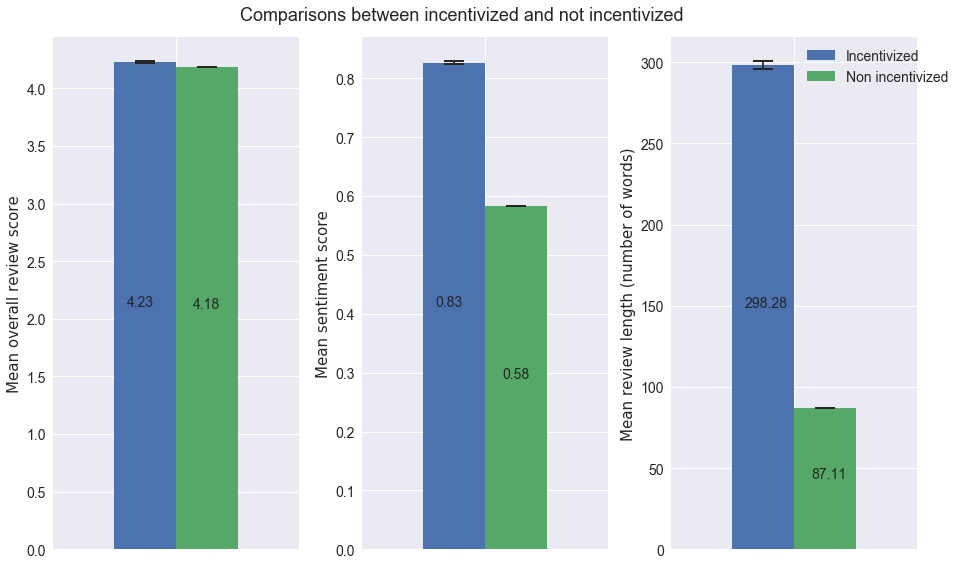

In [20]:
title = ['avg_overall', 'avg_compound', 'avg_word_count']
data_incent = {t: [group['_c0'] for sample in incent2[t] for group in sample] for t in title}
data_non_incent = {t: [group['_c0'] for sample in non_incent2[t] for group in sample] for t in title}

mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2

fig, axs = plt.subplots(1,3,figsize=FIGSIZE)
for id, ax in enumerate(axs):
    plot_with_conf_interval({title[id]: data_incent[title[id]]}, {title[id]: data_non_incent[title[id]]}, ax=ax)
    ax.set_xticklabels('')
    incent_mean, non_incent_mean = np.mean(data_incent[title[id]]), np.mean(data_non_incent[title[id]])
    ax.text(x=-0.2, y=incent_mean/2, s=str(np.round(incent_mean,2)), fontsize=14)
    ax.text(x= 0.07, y=non_incent_mean/2, s=str(np.round(non_incent_mean,2)), fontsize=14)
    if id!=2:
        ax.legend().remove()
    else:
        ax.legend(bbox_to_anchor=(0.5, 1), fontsize=14)

axs[0].set_ylabel('Mean overall review score', font)
axs[1].set_ylabel('Mean sentiment score', font)
axs[2].set_ylabel('Mean review length (number of words)', font)
plt.suptitle('Comparisons between incentivized and not incentivized', fontsize=18)
plt.tight_layout(rect=(0,0,1,0.95))

fig.savefig('comp_incent.png', bbox_inches='tight')

# Whole dataset

In [21]:
def plot_with_conf_interval_single(data, confidence=0.95, ax=None, sort_value=False):
    conf = {k: confidence_interval(v, confidence) for k, v in data.items()}
    means = {k: v[0] for k, v in conf.items()}
    errs = {k: v[2] - v[1] for k, v in conf.items()}
    
    df_value = pd.DataFrame({'Whole dataset': means})
    df_error = pd.DataFrame({'Whole dataset': errs})
    
    if sort_value:
        df_value.sort_values(by='Whole dataset', inplace=True)
        df_error = df_error.loc[df_value.index.values]
    
    dict_barplot(df_value, df_error, ax=ax) 

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


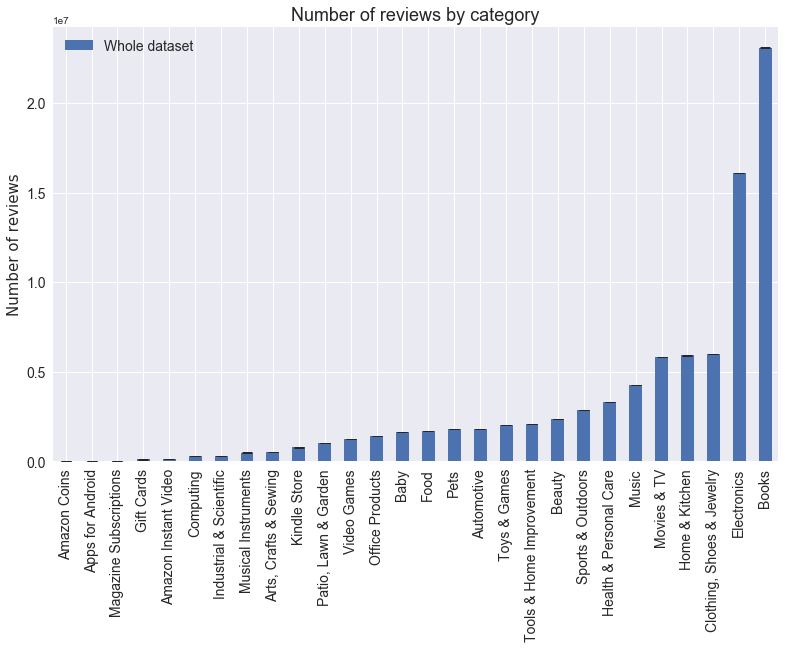

In [22]:
title = 'num_reviews_by_category'

mpl.rcParams['errorbar.capsize'] = 5
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval_single(whole_dataset_by_category[title], ax=ax, sort_value=True)

ax.set_xlabel('', font)
ax.set_ylabel('Number of reviews', font)
plt.title('Number of reviews by category', fontsize=18)
fig.savefig('whole_' + title + '.png', bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


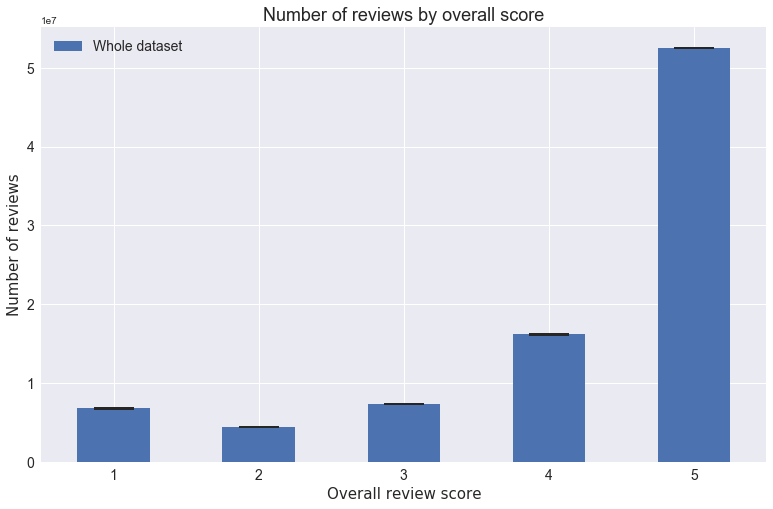

In [23]:
title = 'num_reviews_by_overall'

mpl.rcParams['errorbar.capsize'] = 20
mpl.rcParams['lines.markeredgewidth'] = 2
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval_single(whole_dataset_by_overall[title], ax=ax)

ax.set_xlabel('Overall review score', font)
ax.set_ylabel('Number of reviews', font)
plt.xticks(rotation=0)
plt.title('Number of reviews by overall score', fontsize=18)
fig.savefig('whole_' + title + '.png', bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


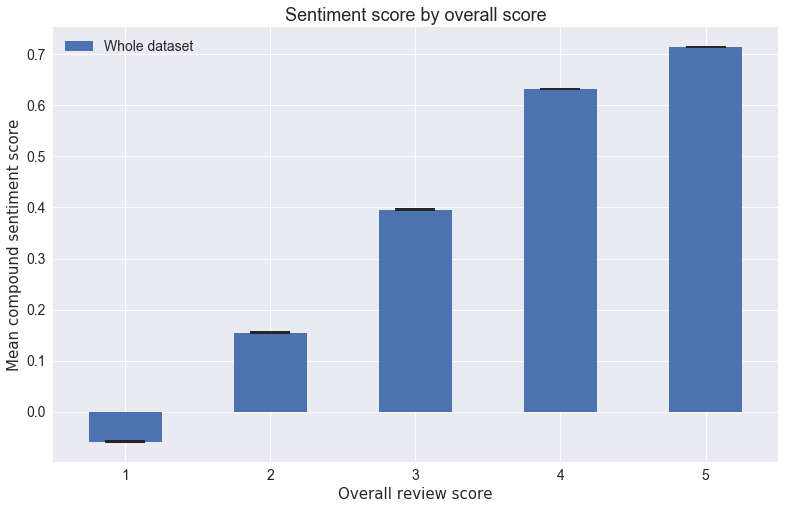

In [24]:
title = 'avg_compound_by_overall'

mpl.rcParams['errorbar.capsize'] = 20
mpl.rcParams['lines.markeredgewidth'] = 2
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval_single(whole_dataset_by_overall[title], ax=ax)

ax.set_xlabel('Overall review score', font)
ax.set_ylabel('Mean compound sentiment score', font)
plt.xticks(rotation=0)
plt.title('Sentiment score by overall score', fontsize=18)
fig.savefig('whole_' + title + '.png', bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


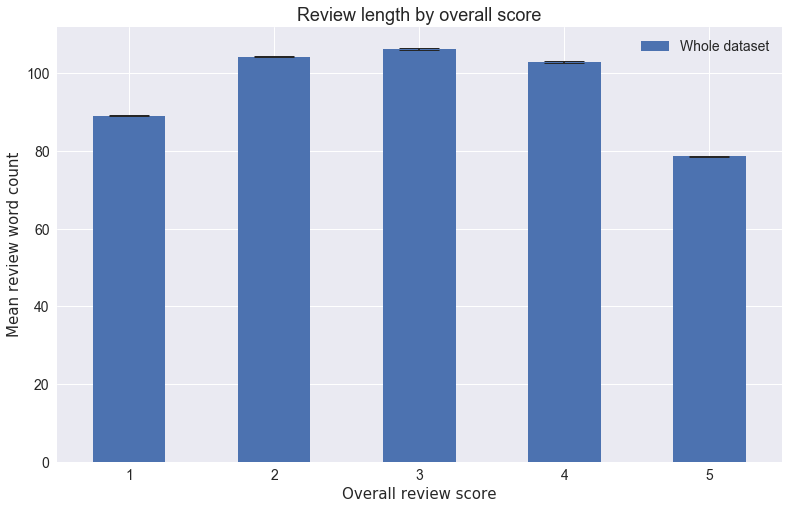

In [25]:
title = 'avg_length_by_overall'

mpl.rcParams['errorbar.capsize'] = 20
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval_single(whole_dataset_by_overall[title], ax=ax)

ax.set_xlabel('Overall review score', font)
ax.set_ylabel('Mean review word count', font)
plt.xticks(rotation=0)
plt.title('Review length by overall score', fontsize=18)
fig.savefig('whole_' + title + '.png', bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


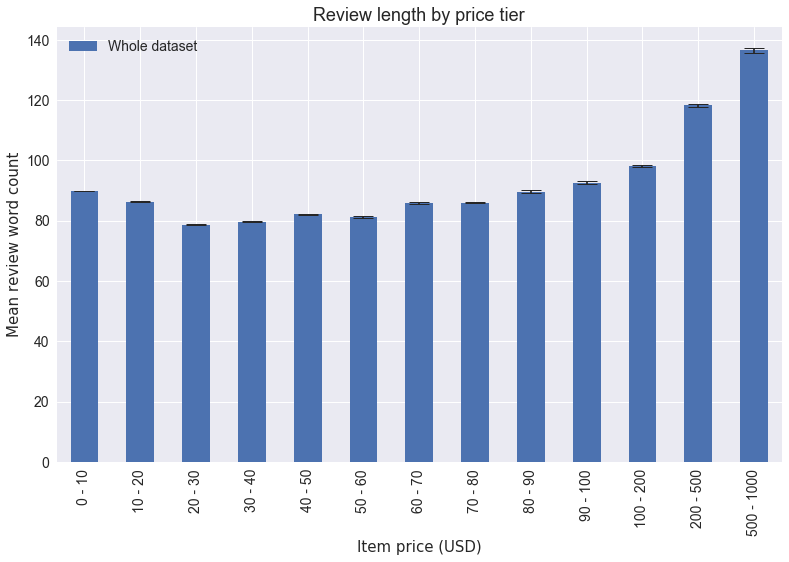

In [26]:
title = 'avg_length_by_price_tier'

mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval_single(whole_dataset_by_price_tier[title], ax=ax)

ax.set_xlabel('Item price (USD)', font)
ax.set_ylabel('Mean review word count', font)
ax.set_xticklabels(bin_labels)
plt.title('Review length by price tier', fontsize=18)
fig.savefig('whole_' + title + '.png', bbox_inches='tight')

In [27]:
whole_compound_data_by_bin = np.asarray([data for bins, data in whole_dataset['compound_histogram']]).T
whole_compound_bin_labels = ['{:.2f} - {:.2f}'.format(b1, b2) for b1, b2 in bigrams(whole_dataset['compound_histogram'][0][0])]
whole_dataset_compound_hist = dict(zip(range(len(whole_compound_data_by_bin)), whole_compound_data_by_bin))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


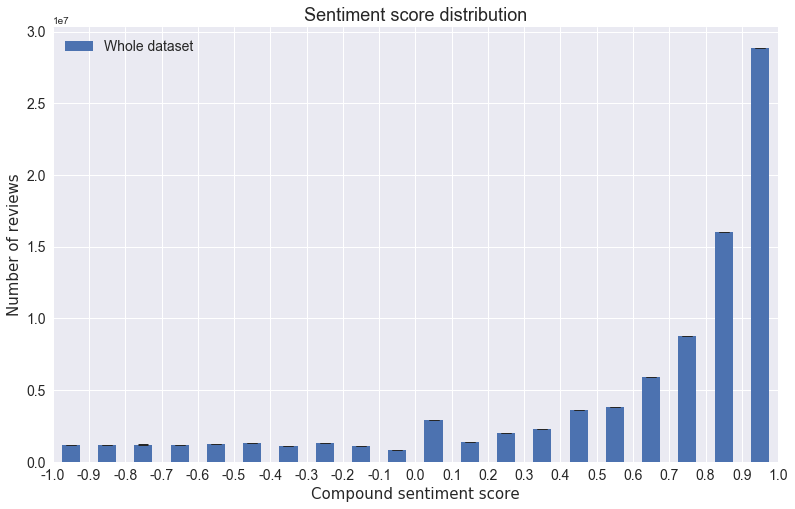

In [28]:
title = 'compound_score_hist'

mpl.rcParams['errorbar.capsize'] = 5
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval_single(whole_dataset_compound_hist, ax=ax)

ax.set_xlabel('Compound sentiment score', font)
ax.set_ylabel('Number of reviews', font)
# ax.set_xticklabels(whole_compound_bin_labels)
ax.set_xticks(np.linspace(-0.5,19.5,21))
bins = whole_dataset['compound_histogram'][0][0]
ax.set_xticklabels(list(map(lambda x: np.round(x, 1), bins)))
plt.xticks(rotation=0)
plt.title('Sentiment score distribution', fontsize=18)
fig.savefig('whole_' + title + '.png', bbox_inches='tight')

# Incentivized reviews of electronics

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


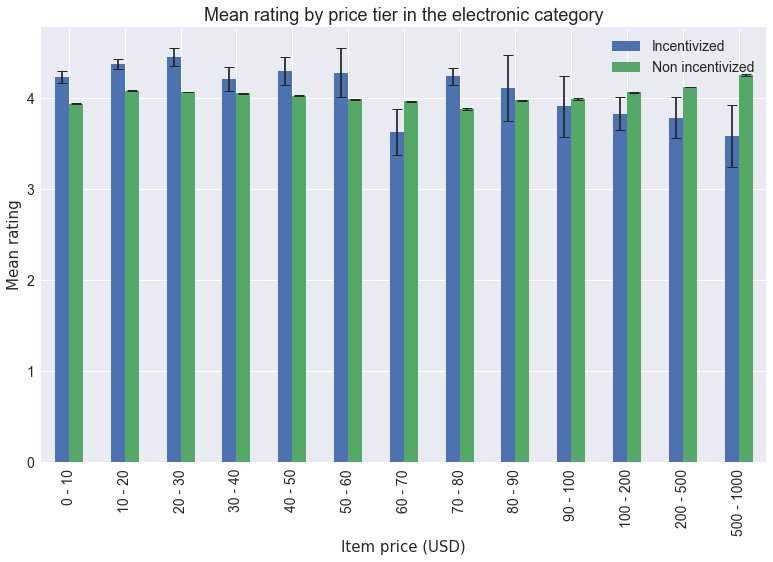

In [29]:
title = 'avg_rating_by_price_tier'

mpl.rcParams['errorbar.capsize'] = 5
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(elec_incent_by_price_tier[title], elec_non_incent_by_price_tier[title], ax=ax)

ax.set_xlabel('Item price (USD)', font)
ax.set_ylabel('Mean rating', font)
ax.set_xticklabels(bin_labels)
plt.title('Mean rating by price tier in the electronic category', fontsize=18)
fig.savefig('elec_' + title + '.png', bbox_inches='tight')

avg_length_by_overall


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


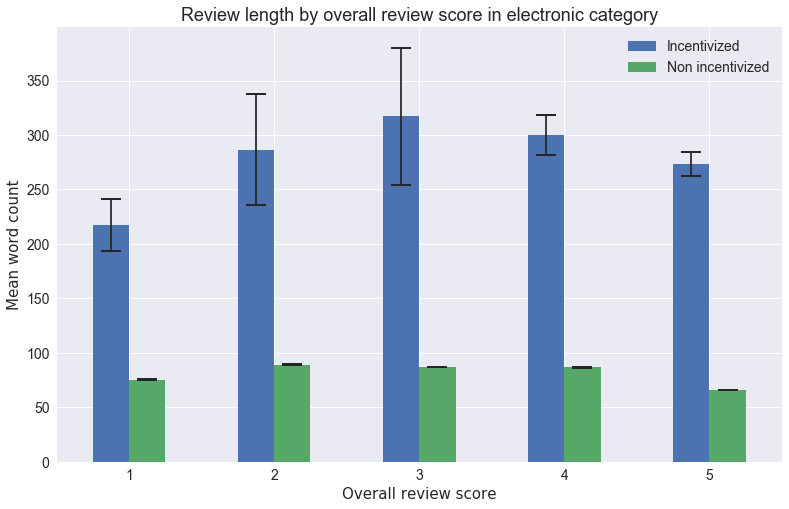

In [30]:
title = 'avg_length_by_overall'
print(title)

mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(elec_incent_by_overall[title], elec_non_incent_by_overall[title], ax=ax)

ax.set_xlabel('Overall review score', font)
ax.set_ylabel('Mean word count', font)
plt.xticks(rotation=0)
plt.title('Review length by overall review score in electronic category', fontsize=18)
fig.savefig('elec_' + title + '.png', bbox_inches='tight')

avg_length_by_price_tier


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


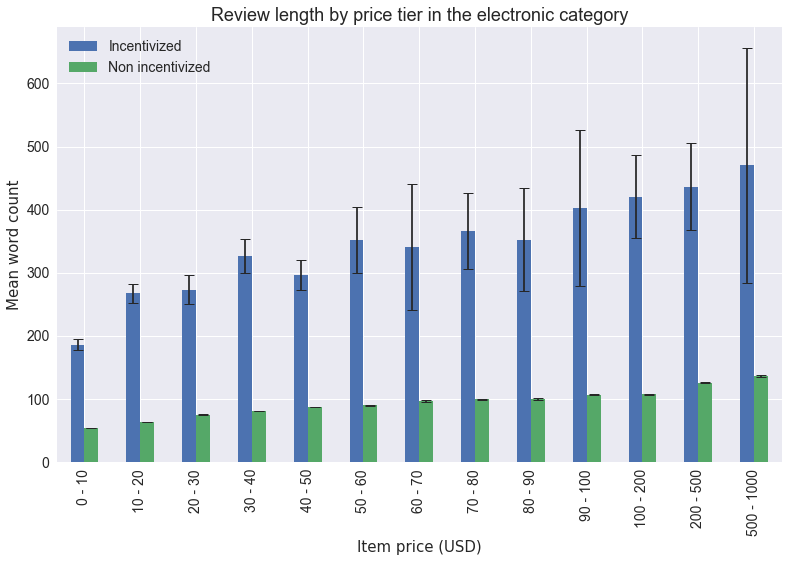

In [31]:
title = 'avg_length_by_price_tier'
print(title)

mpl.rcParams['errorbar.capsize'] = 5
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(elec_incent_by_price_tier[title], elec_non_incent_by_price_tier[title], ax=ax)

ax.set_xlabel('Item price (USD)', font)
ax.set_ylabel('Mean word count', font)
ax.set_xticklabels(bin_labels)
plt.title('Review length by price tier in the electronic category', fontsize=18)
fig.savefig('elec_' + title + '.png', bbox_inches='tight')

avg_compound_by_rating


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


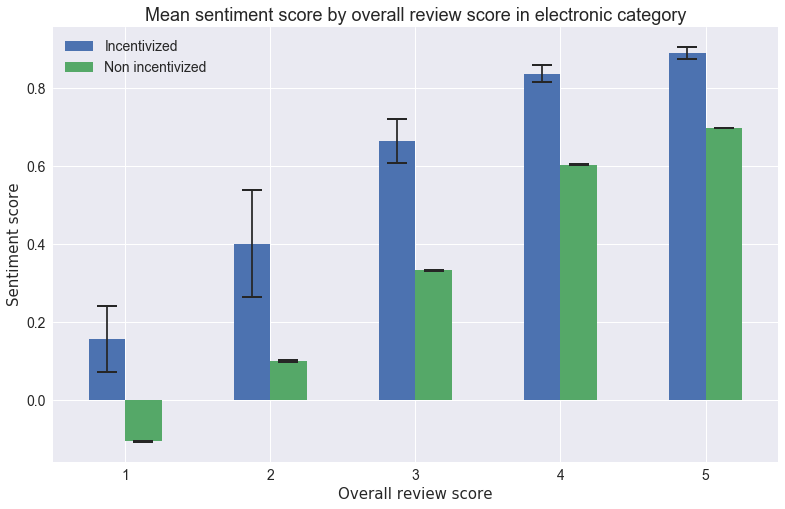

In [32]:
title = 'avg_compound_by_rating'
print(title)

mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(elec_incent_by_overall[title], elec_non_incent_by_overall[title], ax=ax)

ax.set_xlabel('Overall review score', font)
ax.set_ylabel('Sentiment score', font)
plt.xticks(rotation=0)
plt.title('Mean sentiment score by overall review score in electronic category', fontsize=18)
fig.savefig('elec_' + title + '.png', bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


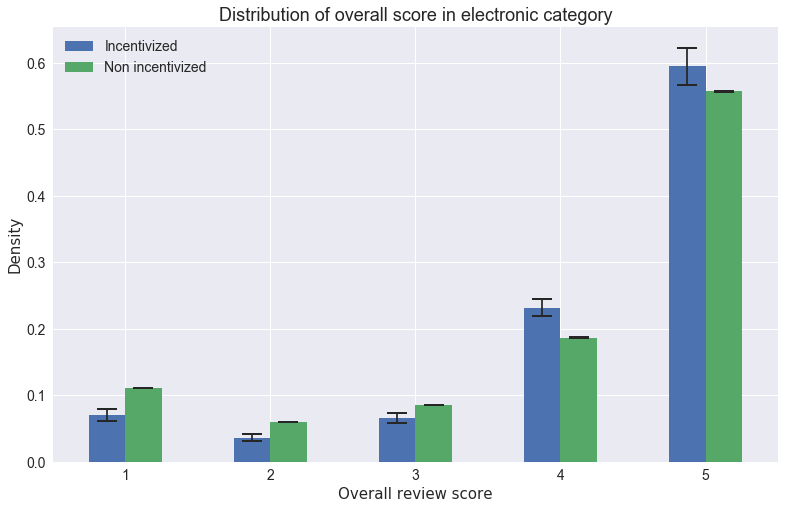

In [33]:
title = 'num_reviews_by_overall'

mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2
fig, ax = plt.subplots(figsize=FIGSIZE)
# plot_with_conf_interval_single(elec_incent_by_overall[title], ax=ax)
plot_with_conf_interval(elec_incent_by_overall[title], elec_non_incent_by_overall[title], ax=ax, normalize=True)


ax.set_xlabel('Overall review score', font)
ax.set_ylabel('Density', font)
plt.xticks(rotation=0)
plt.title('Distribution of overall score in electronic category', fontsize=18)
fig.savefig('elec_' + title + '.png', bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


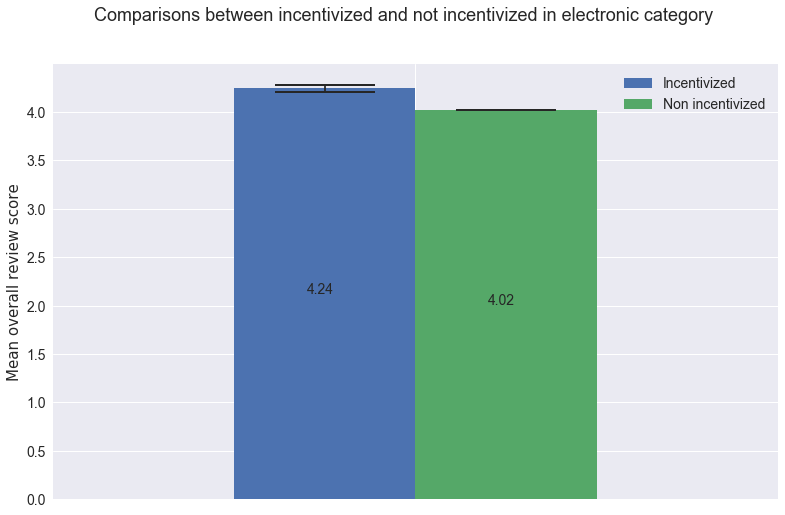

In [36]:
title = ['avg_rating']
data_incent = {t: [group['_c0'] for sample in elec_incent3[t] for group in sample] for t in title}
data_non_incent = {t: [group['_c0'] for sample in elec_non_incent3[t] for group in sample] for t in title}

mpl.rcParams['errorbar.capsize'] = 50
mpl.rcParams['lines.markeredgewidth'] = 2

fig, ax = plt.subplots(1,1,figsize=FIGSIZE)
for id, ax in enumerate([ax]):
    plot_with_conf_interval({title[id]: data_incent[title[id]]}, {title[id]: data_non_incent[title[id]]}, ax=ax)
    ax.set_xticklabels('')
    incent_mean, non_incent_mean = np.mean(data_incent[title[id]]), np.mean(data_non_incent[title[id]])
    ax.text(x=-0.15, y=incent_mean/2, s=str(np.round(incent_mean,2)), fontsize=14)
    ax.text(x= 0.1, y=non_incent_mean/2, s=str(np.round(non_incent_mean,2)), fontsize=14)

ax.set_ylabel('Mean overall review score', font)
plt.suptitle('Comparisons between incentivized and not incentivized in electronic category', fontsize=18)

fig.savefig('elec_comp_incent.png', bbox_inches='tight')